## Pneumonia detection

Image classification challenge: trying to use chest x-rays to detect pneumonia in patients (i.e., assign a status of “pneumonia” or “normal” to each image)

### Dataset

[Chest-xray-pneumonia](http://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
* Folders `__MACOSX` and `chest_xray` are redundant, remove them.
* Every folder has two subfolders: `NORMAL` and `PNEUMONIA` that contain images of x-rays.

### Split and Visualize the Data

Validation set folder has only 16 images. That's too little. Let's re-split data to training, validation and test sets ourselves.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from imutils import paths
from sklearn.model_selection import train_test_split

def generate_dataframe(directory):
    img_paths = list(paths.list_images(directory))
    labels = ['normal' if path.find('NORMAL') > -1 else 'pn' for path in img_paths]
    return pd.DataFrame({ 'paths': img_paths, 'labels': labels })

# df contains paths to all images with corresponding labels
all_df = generate_dataframe('/home/przemek/Deep Learning/road-to-deep-learning/road-to-deep-learning/data/pneumonia-xrays/chest_xray')

train_dataset, test_dateset = train_test_split(all_df, test_size=0.2, random_state=42)

print(train_dataset['labels'].value_counts())
print(test_dateset['labels'].value_counts())

pn        3440
normal    1244
Name: labels, dtype: int64
pn        833
normal    339
Name: labels, dtype: int64


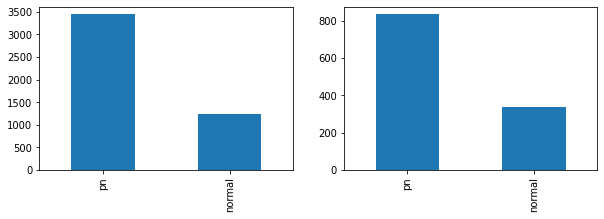

In [3]:
# show plots to check if datasets data distributions are similar
fig = plt.figure(figsize=(10,3))
for idx, dataset in enumerate([train_dataset, test_dateset]):
    fig.add_subplot(1,2,idx+1)
    dataset['labels'].value_counts().plot(kind='bar')

### Create Data Generators And Data Augmentation

Data generators are the way that our network can actually use the training
and test data we have stored in our data frames. Since our data frame only
contains the path to the image and the label, we would ideally like some
way of automatically reading those images into the computer’s memory so
that our soon-to-be-made neural network program can actually learn on it
(or be evaluated on images).

Steps for getting it into the network are roughly as follows:
* Read the picture files.
* Decode the JPEG content to RGB grids of pixels.
* Convert these into floating-point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know,
  neural networks prefer to deal with small input values).

Fortunately Keras has utilities to take care of these steps automatically.

Question:
* What is the purpose of data augmentation process?


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_generators(train_dataset, test_dateset, size=224, batch=64):
    train_generator = ImageDataGenerator(
        rescale=1./255, # multiply each pixel by value
        # augmentation params
        rotation_range=5, # randomly rotate each image by 0 to 5 degrees
        width_shift_range=0.1, # shift image horizontally by 0-10%
        height_shift_range=0.1, # shift image vertically by 0-10%
        validation_split=0.2  # creates two 'subsets': training and validation
    )
    # test on the data without any transformations (original data distribution!)
    test_generator = ImageDataGenerator(rescale=1./255)

    baseargs = {
        "x_col": 'paths',
        "y_col": 'labels',
        "class_labels": ['normal', 'pn'],
        "class_mode": 'binary',  # binary classification
        "target_size": (size, size),  # we can resize the images
        "batch_size": batch, # the number of images we present to the neural network at once
        "seed": 42
    }
    train_generator_flow = train_generator.flow_from_dataframe(
        **baseargs,
        dataframe=train_dataset,  # source data frame
        subset='training')
    validation_generator_flow = train_generator.flow_from_dataframe(
        **baseargs,
        dataframe=train_dataset,
        subset='validation')
    test_generator_flow = test_generator.flow_from_dataframe(
        dataframe=test_dateset,
        shuffle=False,
        **baseargs)

    return train_generator_flow, validation_generator_flow, test_generator_flow

Found 3748 validated image filenames belonging to 2 classes.
Found 936 validated image filenames belonging to 2 classes.
Found 1172 validated image filenames belonging to 2 classes.
(224, 224, 3)


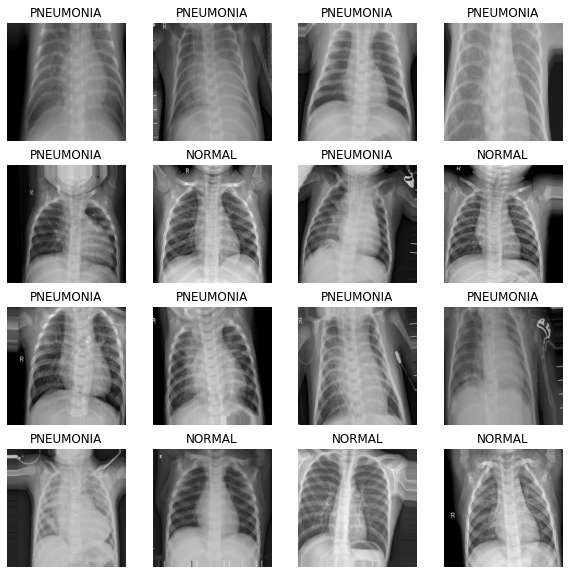

In [5]:
train_generator, validation_generator, test_generator = create_generators(train_dataset, test_dateset, 224, 32)

# display few images from training generator
imgs = train_generator.next() # get the first batch of images (16 images, 16 labels)
print(imgs[0][0].shape)
fig = plt.figure(figsize=(10,10), facecolor='white')
for i in range(16):
    fig.add_subplot(4,4,i+1)
    image = imgs[0][i]
    label = 'PNEUMONIA' if imgs[1][i] == 1 else 'NORMAL'
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)

### VGG16

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16


In [7]:
SIZE = 224
def make_VGGnet():
    m = VGG16(weights = 'imagenet',
              include_top = False,
              input_shape = (SIZE, SIZE, 3))
    for layer in m.layers:
        layer.trainable = False

    x = Flatten()(m.output)
    x = Dense(4096, activation="relu")(x)
    x = Dense(1072, activation="relu")(x)
    x = Dropout(0.2)(x)
    predictions = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=m.input, outputs=predictions)
    ## Compile and run

    adam = Adam(learning_rate=0.001)
    model.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy', Recall(name='recall'),
                           Precision(name='precision'), AUC(name='auc')])
    return model

### Set up 'callbacks'

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from datetime import datetime

def get_callbacks():
    logdir = (
        f'logs/scalars/vgg_{datetime.now().strftime("%m%d%Y-%H%M%S")}'
    )
    tb = TensorBoard(log_dir=logdir)
    es = EarlyStopping(
        monitor="val_loss",
        min_delta=1,  # model should improve by at least 1%
        patience=20,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=2,
        mode="min",
        restore_best_weights=True,  # restore the best model with the lowest validation error
    )
    mc = ModelCheckpoint(f'model_vgg.hdf5',
                         save_best_only=True,
                         monitor='val_loss',
                         mode='min')

    ## Reduce learning rate if it gets stuck in a plateau
    rlr = ReduceLROnPlateau(monitor='val_loss',
                            factor=0.3,
                            patience=3,
                            min_lr=0.000001,
                            verbose=1)
    return [tb, es, mc, rlr]

### Fit the model

In [9]:
from tensorflow.keras.utils import plot_model

def fit_model(train_generator, validation_generator, batch_size=32, epochs=15):
    model = make_VGGnet()
    model.summary()
    plot_model(model, to_file='vgg16.jpg', show_shapes=True)

    model_history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_steps=validation_generator.n/batch_size,
                              epochs=epochs,
                              verbose=1,
                              callbacks=get_callbacks())  # set up callbacks
    return model, model_history

In [10]:
vgg_model, vgg_model_hist = fit_model(train_generator, validation_generator, epochs=15)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
def plot_history(history):

    fig = plt.figure(figsize = (18 , 6))

    fig.add_subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train loss', 'valid loss'])
    plt.grid(True)
    plt.plot()

    fig.add_subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train acc', 'valid acc'])
    plt.grid(True)
    plt.plot()

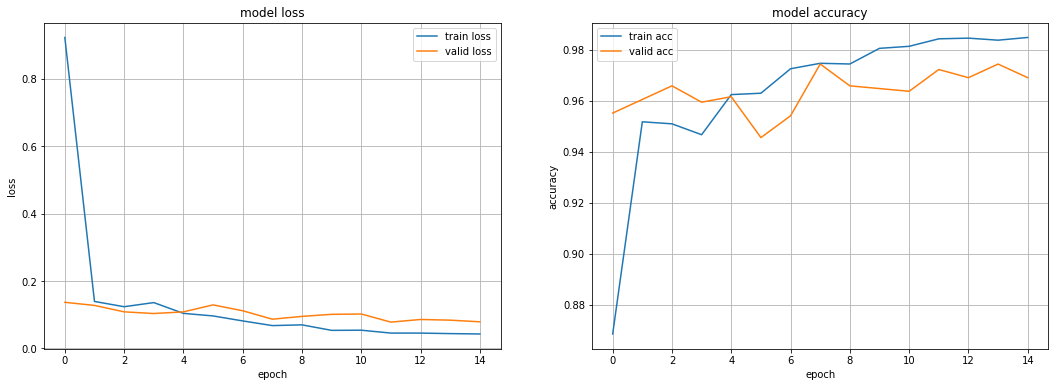

In [12]:
plot_history(vgg_model_hist)

### Tensorboard

In [18]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

### Visualize model attention with GradCAM

In [25]:
!pip install scikit-image

     |████████████████████████████████| 12.4 MB 6.0 MB/s            
     |████████████████████████████████| 3.3 MB 4.7 MB/s            
     |████████████████████████████████| 148 kB 5.0 MB/s            


In [19]:
!git clone https://github.com/gkeechin/vizgradcam.git
!cp vizgradcam/gradcam.py gradcam.py

fatal: destination path 'vizgradcam' already exists and is not an empty directory.


In [1]:
from gradcam import VizGradCAM

def display_map_and_conf(model, test_generator):
    imgs = test_generator.next()
    fig = plt.figure(figsize=(15,5), facecolor='white')

    for i in range(3):
        fig.add_subplot(1,3,i+1)
        image = imgs[0][i]
        label = 'PNEUMONIA' if imgs[1][i] == 1 else 'NORMAL'
        VizGradCAM(model, image, plot_results=True, interpolant=0.5)
        out_prob = model.predict(image.reshape(1,224,224,3))[0][0]
        title = f"Prediction: {'PNEUMONIA' if out_prob > 0.5 else 'NORMAL'}\n"
        title += f"Prob(Pneumonia): {out_prob}\n"
        title += f"True Label: {label}\n"
        plt.title(title)

In [2]:
display_map_and_conf(vgg_model, test_generator)

NameError: name 'vgg_model' is not defined

### Evaluation on any image

In [1]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def predict_image(model, img_path):
    img = img_to_array(load_img(img_path, target_size=(224,224,3)))
    img = img * (1./255)
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    label = 'PNEUMONIA' if pred >= 0.5 else 'NORMAL'
    print("prediction: ", label, "P(Pneumonia): ", pred[0][0])

In [2]:
from tensorflow.keras.models import load_model

m = load_model('model_vgg.hdf5')
predict_image(m, '/home/przemek/Deep Learning/road-to-deep-learning/road-to-deep-learning/data/pneumonia-xrays/chest_xray/train/NORMAL/IM-0410-0001.jpeg')

prediction:  NORMAL P(Pneumonia):  6.303582e-05


### Evaluation on test set

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay)

m = load_model('model_vgg.hdf5')
predictions = m.predict(test_generator)
predicted_classes = [1 if x>0.5 else 0 for x in predictions]
true_classes = test_generator.classes

print(classification_report(true_classes, predicted_classes, target_names=["normal", "pn"]))

cm = confusion_matrix(true_classes, predicted_classes)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'pn'])
cm_disp.plot(values_format='')